# Eliminación del reflejo en una imagen.

In [1]:
import numpy as np
import cv2
import copy
import math
from matplotlib import pyplot as plt

## 0. Tabla de contenidos.
>* [Introducción](#introduccion)
* [Funciones auxiliares](#faux)
* [Esquema del algoritmo](#esquema)
    * [Precálculos](#precalculos)
    * [Proceso iterativo](#iteraciones)
        * [Actualización de g_i_j](#actualizacion)
        * [Cálculo de L1](#calculol1)
        * [Normalización](#normalizacion)
    * [Cálculo de L2 y últimos ajustes](#calculol2)
* [Algoritmo final](#algoritmo)
* [Experimentación](#experimentacion)
    * [Alterando el número de iteraciones del proceso de optimización](#iteraciones)
    * [Alterando el valor de beta](#beta)
    * [Alterando el valor de lambda](#lambda)
    * [Comprobando salidas de partes de la fórmula de L1](#partesL1)
* [Conclusiones](#conclusiones)
* [Referencias](#referencias)

## 1. Introducción. <a class="anchor" id="introduccion"></a>

> **Abstract:**
El trabajo presenta la implementación de un algoritmo de eliminación del reflejo en una imagen a partir de la misma a partir del artículo *Single Image Layer Separation using Relative Smoothness* de Yu Li y Michael S. Brown [[3]](#articulo) [[4]](#code). En este, se busca la separación en capas de una imagen asumiendo que una de las mismas es más suave que la otra. La estrategia utilizada utiliza la regularización del gradiente de las dos capas atribuyendo a estas una distribución de cola larga y otra corta para sus gradientes.

&emsp;&emsp;**Autores:** Marcel Espejo Cuenca, Álvaro Campillos Delgado.
<br>
&emsp;&emsp;**Curso:** 2020/2021.

&emsp;&emsp;*Procesamiento de Imágenes Digitales*
***

A continuación se detallan el conjunto de librerías utilizadas en la implementación del algoritmo que han sido importadas anteriormente:
    - Numpy: Operar con las matrices que representan a las imágenes de forma eficiente y rápida.
    - OpenCV: Operaciones de filtrado, mostrado y transformación.
    - Copy: Copias profundas de distintos elementos.

Realizamos la lectura de la imagen a la que queremos aplicar el algoritmo de eliminación del reflejo. Utilizamos la función imread de OpenCV con cuyos parámetros podemos hacer que  sea leida en escala de grises medainte "cv2.IMREAD_GRAYSCALE".

Forma: (725, 480, 3)
Tipo de la matriz: <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Original')

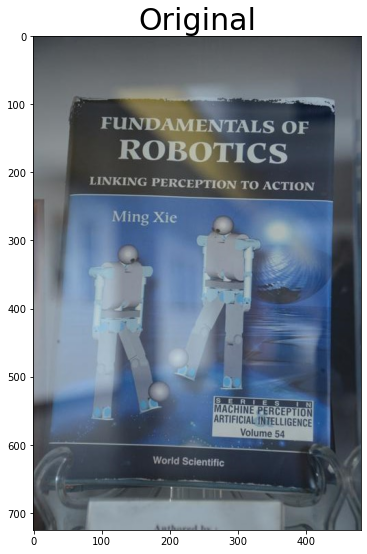

In [2]:
# Lectura de la imagen
#img = cv2.imread('reflection_in.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.imread('reflection_in.jpg')
print("Forma: " + str(img.shape))
print("Tipo de la matriz: " + str(type(img)))

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)
#cv2.imshow('imagen', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## 2. Funciones auxiliares. <a class="anchor" id="faux"></a>

Utilizamos un conjunto de funciones auxiliares que se desarrollan a continuación.
    - im2doubleAux(I): Realiza la normalización de la imagen de [0..255] a [0. .. 1.]. La normalización se realiza según la  fórmula:
    
$$z_i = \frac{x_i - min(x)}{max(x)-min(x)}$$    
    
           dónde x = (x_1,...,x_n) y z_i es el dato i-ésimo normalizado.
       El uso de esta función se debe a que los cálculos los realizamos con mayor facilidad en este rango.


In [3]:
def im2doubleAux(I):
    """Fucnion auxiliar para normalizar una imagen 
    en el rango [0. - 1.] según la formula (x_i - min) / (max - min)
    Parametros:
    ----------
    I: `numpy.ndarray`
    
    Salida:
    ----------
    salida: `numpy.ndarray`
    """
    if (len(I.shape)==3):
        n,m,d = I.shape
    elif (len(I.shape)==2):
        n,m = I.shape
        
    # Calculo del minimo y el maximo
    maximo = np.max(I)
    minimo = np.min(I)
    salida = np.empty(I.shape).astype('float64')
    for linea in range(n):
        for col in range(m):
            if (len(I.shape)==3):
                for dim in range(d):
                    # aplicar a cada pixel la formula (x_i - min) / (max - min)
                    salida[linea,col,dim] = ((I[linea,col,dim])-minimo)/(maximo-minimo)
            elif (len(I.shape)==2):
                salida[linea,col] = ((I[linea,col])-minimo)/(maximo-minimo)
    return salida

   Podemos calcular las funciones de los distintos filtros que convolucionamos con la imagen en el dominio espacial a su correspondiente en el dominio de la frecuencia puesto que todas las operaciones se realizan en este.
En el dominio espacial estos filtros representan funciones de dispersión de puntos (point-spread function, PSF) cuyo equivalente es una función de transferencia óptica (optical-transfer function, OTF). Las OTF no estará influenciada por el descentralizado. [1](#enlacePSF2OTF)

       - zero_pad(image, shape, [position]): Realiza un reescalado de la imagen de entrada a las dimensiones dadas añadiendo ceros.
    
       - psf2otf(psf, shape): Realiza la transformación de las PSF a las OTF correspondientes a través de la transformada rápida de Fourier (FFT).

In [4]:
# Fuente: https://github.com/aboucaud/pypher/blob/master/pypher/pypher.py
def zero_pad(image, shape, position='corner'):
    """
    Se amplia la imagen a un cierto tamaño añadiendo ceros
    Parametros:
    ----------
    image: `numpy.ndarray` 2d de reales
        Imagen de entrada
    shape: tupla de enteros
        Tamaño de la imagen de salida
    position: str, opcional
        Posicion de la imagen de entrada en la imagen de salida:
            * 'corner'
                esquina superior izquierda (por defecto)
            * 'center'
                centrado
    Salida
    -------
    imagen_ampliada: real `numpy.ndarray`
        La imagen ampliada
    """
    shape = np.asarray(shape, dtype=int)
    imshape = np.asarray(image.shape, dtype=int)

    if np.alltrue(imshape == shape):
        return image

    if np.any(shape <= 0):
        raise ValueError("ZERO_PAD: se ha dado tamaño nulo o negativo")

    dshape = shape - imshape
    if np.any(dshape < 0):
        raise ValueError("ZERO_PAD: tamaño de salida menor que el de entrada")

    pad_img = np.zeros(shape, dtype=image.dtype)

    idx, idy = np.indices(imshape)

    if position == 'center':
        if np.any(dshape % 2 != 0):
            raise ValueError("ZERO_PAD: distinta paridad de tamaños "
                             "de entrada y salida.")
        offx, offy = dshape // 2
    else:
        offx, offy = (0, 0)

    pad_img[idx + offx, idy + offy] = image

    return pad_img


def psf2otf(psf, shape, testFormaPSF = False):
    """
    Convierte la funcion de dispersion de puntos en una 
    funcion de transferencia otica.
    Calcula la transformada rapida de Fourier (FFT) de la función de dispersión de
    puntos (PSF) y crea la funcion de transferencia óptica (OTF) que no
    esta influenciado por el descentrado de PSF.
    Por defecto el tamaño de OTF es el mismo que el de PSF.
    Para asegurar que OTF no esta alterado por el descentrado de PSF,
    se realiza un reescalado con ceros para que las dimensiones encajen,
    despues se desplazan los valores de PSF circularmente hasta que el pixel
    central alcanza la posicion (0,0)
    position.
    Parametros
    ----------
    psf : `numpy.ndarray`
        matriz PSF
    shape : int
        Tamaño de salida de la matriz OTF
    testFormaPSF: Bool, opcional
        Si no se especifica es falso, sirve para ver la forma que tiene la psf
    Salida
    -------
    otf : `numpy.ndarray`
        matriz OTF
    Notas
    -----
    Funcion adaptada de MATLAB psf2otf
    """
    if np.all(psf == 0):
        return np.zeros_like(psf)

    inshape = psf.shape
    # Hacer el pad de PSF para el tamaño de salida
    psf = zero_pad(psf, shape, position='corner')
    if testFormaPSF:
        print(psf)
    # Desplazar valores de OTF circularmente para que el centro de PSF
    # sea el elemento [0,0] de la matriz
    for axis, axis_size in enumerate(inshape):
        psf = np.roll(psf, -int(axis_size / 2), axis=axis)

    # Hacer la transformada de Fourier
    otf = np.fft.fft2(psf)

    # Estimar la cantidad de operaciones que actuan en la FFT y 
    # descartar la parte imaginaria de PSF si esta dentro de roundoff error
    # roundoff error  = machine epsilon = sys.float_info.epsilon
    # or np.finfo().eps
    n_ops = np.sum(psf.size * np.log2(psf.shape))
    otf = np.real_if_close(otf, tol=n_ops)

    return otf

## 3. Esquema del algoritmo. <a class="anchor" id="esquema"></a>

En el artículo se proporciona el siguiente pseudocódigo que seguiremos para la implementación del algoritmo. Desarrollaremos las distintas secciones en profundidad para finalmente proporcionar el algoritmo al completo.

<img src="pseudocodigo.png" width="500" height="500">

Esquema que seguido a lo largo del notebook:


     1) Precálculos
     2) Proceso iterativo
         2.1) Actualización de g
         2.2) Cálculo de L1
         2.3) Normalización
     3) Cálculo de L2 y últimos ajustes

### 3.1. Precálculos. <a class="anchor" id="precalculos"></a>

Inicializamos las variables que vamos a necesitar para el desarrollo de las distintas partes y que serán pasadas por parámetros a la función.

    - La imagen debe estar normalizada en el rango [0,..,1], para lo que utilizamos la función que hemos definido anteriormente (im2double(img)).
    
    - lb es una matriz de ceros que represeta el valor mínimo que puede tener el elemento de la matriz de la imagen en la misma dimensión.

    - hb la matriz con los valores máximos que se pueden tomar, lo inicializamos al valor inicial que tiene la imagen.

In [5]:
# Imagen que se va a tratar
# Hemos diseñado el algoritmo para que trabaje con reales del 0 al 1
I = im2doubleAux(img)
lb = np.zeros(img.shape)   # lb es una matriz de ceros
hb = I                     # hb tiene los valores de la imagen original
lamb = 50                  # lambda 

Primero se comprueba si la imagen que hemos leido está en escala de grises o no, para ello se comprueba si las dimensiones de la matriz de la imagen es tan sólo 2. En caso de ser asi, para tratarla igual que a una imagen normal a color, se le añaden las dimensiones correspondientes.

In [6]:
if len(I.shape)==2:
    I = np.dstack([I]*1)
    lb = np.dstack([lb]*1)
    hb = np.dstack([hb]*1)

Ahora que sabemos que tipo de imagen tratamos (escala de grises o a color), inicializamos L1 como una copia de la imagen original y obtenemos sus dimensiones según *n,m,d = (filas, columnas, dimensiones)*.

In [7]:
# Inicializar L1_0 en caso de ser necesario
L1 = copy.deepcopy(I)

# tamaño de la matriz/imagen original n x m x d
n,m,d = I.shape  

Inicializamos los diferentes filtros que utilizaremos en el algoritmo, los dos primeros filtros de primer orden, y el tercero un Laplaciano.

In [8]:
# Filtros    
f1 = np.array([[1,-1]])
f2 = np.array([[1],
               [-1]])
# f3 es el filtro laplaciano
f3 = np.array([[0,-1,0],
                [-1,4,-1],
                [0,-1,0]])

Ahora tenemos que conseguir las matrices de OTF (función de transferencia óptica) para cada filtro, donde cada filtro se reescala con el tamaño de la imagen y se pasa al dominio de la frecuencia mediante la transformada de Fourier.
<br><br>
Opera de forma que el filtro se sitúa en la esquina superior izquierda correspondiéndose con la PSF (función de dispersión de puntos).
<br>
Si la PSF es simetrica con respecto a su centro, la OTF no tendrá numeros complejos (caso del filtro laplaciano, f3).

In [9]:
# Calcular las OTF asociadas a cada filtro haciendo uso de 
# la funcion auxiliar psf2otf
sizeI2D = (n,m)
otfFx = psf2otf(f1,sizeI2D,testFormaPSF=True)
otfFy = psf2otf(f2,sizeI2D,testFormaPSF=True)
otfL = psf2otf(f3,sizeI2D,testFormaPSF=True)

[[ 1 -1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ 1  0  0 ...  0  0  0]
 [-1  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ 0 -1  0 ...  0  0  0]
 [-1  4 -1 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


Ahora se calculan partes de fórmula del cálculo de L1, según se indica en las diferentes imágenes.

<img src="campturaFormI.jpg" width="500" height="500">

In [10]:
fft2I = np.empty(I.shape).astype('complex128')
for c in range(d):
    fft2I[:,:,c] = np.fft.fft2(I[:,:,c])

Convolución entre la imagen con su complejo conjugado habiendo aplicado a ambas el filtro Laplaciano.

<img src="capturaFormNromin1.jpg" width="500" height="500">

In [11]:
Normin1 = np.power(np.dstack([np.absolute(otfL)]*d),2) * fft2I

Elementos pertenecientes al denominador  (siendo una de ellas el filtro j-ésimo con índice j del sumatorio de la función de optimización).

<img src="capturaFormDenormin.jpg" width="500" height="500">

In [12]:
Denormin1 = np.power(np.absolute(otfL),2)

Denormin2 = np.power(np.absolute(otfFx),2) + np.power(np.absolute(otfFy),2)
    
# Igualar la cantidad de canales que tiene la imagen original en caso de que sea una
# imagen en escala de grises
if d>1:
    Denormin1 = np.dstack([Denormin1]*d)
    Denormin2 = np.dstack([Denormin2]*d)

Inicialización de las variables necesarias para el cáculo de beta (thr) y la estabilidad del algoritmo (tau).

In [13]:
eps = 10**(-16) # tau
thr = 0.05

### 3.2. Proceso iterativo. <a class="anchor" id="iteraciones"></a>

En el algoritmo se realizan 3 iteraciones con distintos valores de beta, pero para la visualización del proceso en cada paso solo haremos la primera iteración.

Para empezar inicializamos beta y terminamos el cálculo del denominador de la fórmula del cálculo de L1.

In [14]:
# Inicializar beta
i = 1
beta = 2**(i-1)/thr

Denormin = lamb * Denormin1 + beta * Denormin2
# En caso de que la imagen sea en escala de grises
if len(Denormin.shape)==2:
    Denormin=np.dstack([Denormin]*1)

### 3.2.3. Actualización de g_i_j. <a class="anchor" id="actualizacion"></a>

Ahora tratamos la parte de la actualización de g_i_j, empezando con la convolución de la imagen con L1 (que en nuestro caso ahora mismo es la imagen original) que se corresponde con:
$$F_i^{j}*L_1$$

<img src="capturaFormConvol.jpg" width="500" height="500">

En este fragmento se trata de detectar los bordes del fondo a través de las derivadas direccionales del eje x y eje y la operación de umbralización dada en la actualización de las variables g.

In [15]:
# Aplicar los filtros f1 y f2 a L1
gFx = -cv2.filter2D(L1, -1, f1, anchor=(-1,-1),delta=0,borderType=cv2.BORDER_REFLECT_101)
gFy = -cv2.filter2D(L1, -1, f2, anchor=(-1,-1),delta=0, borderType=cv2.BORDER_REFLECT_101)

# Por si es una imagen en escala de grises
if len(gFx.shape) == 2:
    gFx = np.dstack([gFx]*1)
    gFy = np.dstack([gFy]*1)


Se implementa a continuación la parte del umbral, en caso de no superarlo, se cambia el valor en la posición que no lo supera por un 0.

In [16]:
# t_x y t_y son acumuladores, contienen el valor de la suma de los d
# canales en cada pixel, si este valor es menor que el umbral,
# el valor de ese pixel en cada canl se cambia a 0.

for fila in range(n):
    for columna in range(m):
        t_x = 0
        t_y = 0
        for canal in range(d):
            t_x += abs(gFx[fila,columna,canal])
            t_y += abs(gFy[fila,columna,canal])
            # gFx(t) = 0;
        if t_x < 1/beta:
            for canal in range(d):
                gFx[fila,columna,canal] = 0
        if t_y < 1/beta:
            for canal in range(d):
                gFy[fila,columna,canal] = 0
    
cv2.imshow('gFx', gFx)
cv2.imshow('gFy', gFy)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3.2.4. Cálculo de L1. <a class="anchor" id="calculol1"></a>

Terminamos el cálculo de las partes de L1 que no se han podido precalcular o cuyo valor haya variado en el proceso iterativo. En nuestro caso se trata del elemento en el numerador en que interviene la variable g_j que actualizamos en el paso anterior como parte de la optimización.

<img src="capturaFormNormin2.png" width="500" height="500">

In [17]:
# j == 1 primer filtro

temp = gFx[:,m-1,:] - gFx[:,0,:]    # Se obtiene una columna por canal
diff = -np.diff(gFx, 1, 1)          # tiene las dimensiones de siempre
Normin2 = np.empty((n,m,d))

temporalAux = np.empty((n,1,d))
for c in range(d):
    temporalAux[:,0,c] = temp[:,c]

for dim in range(0,d): 
    Normin2[:,:,dim] = np.column_stack((temporalAux[:,0,dim], diff[:,:,dim]))

# j == 2 segundo filtro
        
temp = gFy[n-1,:,:] - gFy[0,:,:]
diff = -np.diff(gFy,1,axis = 0)
Normin2_aux = np.empty((n,m,d))

temporalAux = np.empty((1,m,d))
for c in range(d):
    temporalAux[0,:,c] = temp[:,c]
for dim in range(0,d):
    Normin2_aux[:,:,dim] = np.vstack((temporalAux[0,:,dim],diff[:,:,dim]))


Normin2 = Normin2 + Normin2_aux

Normin2 = Normin2.astype('complex128')
for c in range(d):
    Normin2[:,:,c] = np.fft.fft2(Normin2[:,:,c])

Una vez calculados el numerador y denominador que intervienen el a fórmula de A, podemos calcularla.

Cuando hayamos obtenido su valor obtenemos la capa L1 una vez actualizados sus valores mediante la transformada inversa de Fourier (IFFT).

In [18]:
FL1 = (lamb*Normin1 + beta*Normin2)/(Denormin + eps)
for c in range(d):
    L1[:,:,c] = np.real(np.fft.ifft2(FL1[:,:,c]))
    
cv2.imshow('L1', L1)
cv2.waitKey(0)
cv2.destroyAllWindows()

En este paso aún no se han normalizado los valores de la imagen, de forma que podemos encontrar distorsiones en la misma en forma de colores que no se corresponden con los de la imagen real o puntos de mucha claridad u oscuridad.

### 3.2.5. Normalización. <a class="anchor" id="normalizacion"></a>

Finalmente debemos normalizar la imagen para que todos los valores entren en el rango que hemos definido al principio, con las matrices lb y hb. Para el proceso de minimización de la función objetivo que se presenta debajo utilizamos siguiendo el artículo la técnica del gradiente descendente.

<img src="eqn9.png" width="500" height="500">

In [19]:
# Aplicando la normalizacion a cada canal
for c in range(0, d):
    # Obtener el canal concreto
    L1t = L1[:,:,c]
    for k in range(0, 500):
        dt = 0
        # Se realiza el sumatorio de todos los valores que salen del rango
        # especificado en [lb_i - hb_i]
        dt = dt + np.sum(L1t[L1t<lb[:, :, c]])
        dt = dt + np.sum(L1t[L1t>hb[:, :, c]])
        # Size da el numero de elementos de una matriz en numpy
        dt = dt * 2 / L1t.size
        L1t = L1t - dt
        # En caso de tener una media de elementos que salen del rango menor que 
        # el umbral de 1/total_elementos, se ha terminado de normalizar.
        if np.absolute(dt)< 1/ L1t.size:
            break
    # Asignacion de la nueva capa correspondiente
    L1[:,:,c] = L1t
    
cv2.imshow('L1', L1)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3.2.6. Cálculo de L2 y últimos ajustes. <a class="anchor" id="calculol2"></a>

Hay que comprobar por último que no haya valores que se salgan del rango de [lb_i .. hb_i], los valores que superen el máximo se le da el valor original, en caso de tener un valor inferior al mínimo se le da el valor mínimo posible.
Para calcular L2 (el reflejo) solo hay que hacer I - L1 ya que el reflejo es lo que hemos eliminado.

In [20]:
# Ajuste final de valores que se salen del rango
t = L1<lb
L1[t] = lb[t]
t = L1>hb
L1[t] = hb[t] 
    
# L2 debe ser I - L1
L2 = I - L1

cv2.imshow('L1', L1)
cv2.imshow('L2', L2)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 4. Algoritmo final. <a class="anchor" id="algoritmo"></a>

El algoritmo está implementado en **septRelSmo(I, lambda, lb, hb, [ite=numIteraciones,[thr=umbral, [L1_0]]])**, aquí es donde se realiza la separación de las capas como se describe en el pseudocódigo del artículo con las secciones desarrolladas anteriores unificadas.
<br><br>
Ahora si se aplican 3 iteraciones con los valores de beta 20, 40 y 80.



In [21]:
def septRelSmo(I,lamb,lb,hb, ite = 3, thr = 0.05,L1_0 = None, prints = False):
    """Funcion de separacion de reflejo de una imagen basada
    en Single Image Layer Separation using Relative Smoothness
    Parametros:
    ----------
    I: `numpy.ndarray` con valores float de 0. a 1.
        matriz de entrada que representa la imagen
    lamb: int
        lambda, parametro que controla la suavidad de la salida L2
    lb: `numpy.ndarray` con valores float de 0. a 1. con mismo tamaño que I
        Indica en cada posicion el valor minimo que debe tener la imagen de
        salida en la posicion i-esima (normalmente 0 en todos los valores)
    hb: `numpy.ndarray` con valores float de 0. a 1. con mismo tamaño que I
        Indica en cada posicion el valor maximo que debe tener la imagen de
        salida en la posicion i-esima (normalmente el valor de la I original)
    ite: int 
        numero de iteraciones para el algoritmo
    thr: float
        umbral para el calculo de beta, sirve para calculo de L1 y el umbral
        de la actualizacion de g
    L1_0: `numpy.ndarray del tamaño de I, opcional
        Imagen de partida (por defecto la imagen original)
    prints: Bool
        Indica si deben salir los prints para ver por donde va el algoritmo
    Salida:
    ----------
    L1: `numpy.ndarray`
        capa sin el reflejo
    L2: `numpy.ndarray`
        capa del reflejo
    """       
    
    if len(I.shape)==2:
        I = np.dstack([I]*1)
        lb = np.dstack([lb]*1)
        hb = np.dstack([hb]*1)
        
    
    # Inicializar L1_0 en caso de ser necesario
    if L1_0 == None:
        L1_0 = copy.deepcopy(I)
    
    # tamaño de la matriz/imagen original n x m x d
    n,m,d = I.shape    
    
    # Filtros    
    f1 = np.array([[1,-1]])
    f2 = np.array([[1],
                   [-1]])
    # f3 es el filtro laplaciano
    f3 = np.array([[0,-1,0],
                 [-1,4,-1],
                 [0,-1,0]])
    
    
    # Calcular las OTF asociadas a cada filtro haciendo uso de 
    # la funcion auxiliar psf2otf
    sizeI2D = (n,m)
    otfFx = psf2otf(f1,sizeI2D)
    otfFy = psf2otf(f2,sizeI2D)
    otfL = psf2otf(f3,sizeI2D)
    
    # Calculo de FFT de la imagen de entrada por capas/canales
    fft2I = np.empty(I.shape).astype('complex128')
    for c in range(d):
        fft2I[:,:,c] = np.fft.fft2(I[:,:,c])
    
    
    # Partes de la formula (8) (Compute) que pueden ser precalculadas

    # FFT(F3)*FFT(F3)FFT(I) = ((F3)^2)FFT(I) donde * es el complejo conjugado
    Normin1 = np.power(np.dstack([np.absolute(otfL)]*d),2) * fft2I

    
    # FFT(F3)*FFT(F3) = (F3)^2 donde * es el complejo conjugado
    Denormin1 = np.power(np.absolute(otfL),2)
    
    # sum_j(FFT(Fj)*FFT(Fj)) = sum_j((Fj)^2) donde * es el complejo conjugado
    #     y j es un valor perteneciente a {1,2}, es decir, Fj es otfFx u otfFy
    Denormin2 = np.power(np.absolute(otfFx),2) + np.power(np.absolute(otfFy),2)

    
    
    # Igualar la cantidad de canales que tiene la imagen original
    if d>1:
        Denormin1 = np.dstack([Denormin1]*d)
        Denormin2 = np.dstack([Denormin2]*d)

    
    
    # Constante de la formula (8)
    eps = 10**(-16)    
    
    
    # Inicializar L1
    L1 = L1_0
    
    # Realizar 3 iteraciones variando el valor de beta
    for i in range(1,(ite+1)):
        # Inicializar beta
        beta = 2**(i-1)/thr
        if prints:
            print("Iteración con beta = " + str(beta))
        # Inicializar Denormin de formula (8) con los valores del precalculo
        Denormin = lamb * Denormin1 + beta * Denormin2
        if len(Denormin.shape)==2:
            Denormin=np.dstack([Denormin]*1)
        
        # Actualizar g_j_i con la formula (7)
        if prints:
            print("Actualizando g, beta = " + str(beta))
        """Para cada valor, pasando el filtro,
        si es menor que un cierto umbral, se cambia el valor a 0, 
        en otro caso se mantiene. """
        
        # Aplicar los filtros f1 y f2 a L1
        gFx = -cv2.filter2D(L1, -1, f1, anchor=(-1,-1),delta=0,borderType=cv2.BORDER_REFLECT_101)
        gFy = -cv2.filter2D(L1, -1, f2, anchor=(-1,-1),delta=0, borderType=cv2.BORDER_REFLECT_101)
        
        if len(gFx.shape) == 2:
            gFx = np.dstack([gFx]*1)
            gFy = np.dstack([gFy]*1)
        
        # t_x y t_y son acumuladores, contienen el valor de la suma de los d
        # canales en cada pixel, si este valor es menor que el umbral,
        # el valor de ese pixel en cada canl se cambia a 0.

        for fila in range(n):
            for columna in range(m):
                t_x = 0
                t_y = 0
                for canal in range(d):
                    t_x += abs(gFx[fila,columna,canal])
                    t_y += abs(gFy[fila,columna,canal])
                    # gFx(t) = 0;
                if t_x < 1/beta:
                    for canal in range(d):
                        gFx[fila,columna,canal] = 0
                if t_y < 1/beta:
                    for canal in range(d):
                        gFy[fila,columna,canal] = 0

    
        # Calculo de L1
        if prints:
            print("Calculando L1, beta = " + str(beta))
        
        # Solo queda por calcular la parte de la formula (7) sum_j(FF(Fj)*FFT(gj))
        # que se resuelve usando la propiedad de la transformada de fourer de la
        # transformada de la convolucion.
        
        # j == 1 primer filtro
        
        temp = gFx[:,m-1,:] - gFx[:,0,:]    # Se obtiene una columna por canal
        diff = -np.diff(gFx, 1, 1)          # tiene las dimensiones de siempre
        Normin2 = np.empty((n,m,d))

        
        temporalAux = np.empty((n,1,d))
        for c in range(d):
            temporalAux[:,0,c] = temp[:,c]

        for dim in range(0,d): 
            Normin2[:,:,dim] = np.column_stack((temporalAux[:,0,dim], diff[:,:,dim]))

        # j == 2 segundo filtro
        
        temp = gFy[n-1,:,:] - gFy[0,:,:]
        diff = -np.diff(gFy,1,axis = 0)
        Normin2_aux = np.empty((n,m,d))

        temporalAux = np.empty((1,m,d))
        for c in range(d):
            temporalAux[0,:,c] = temp[:,c]
        for dim in range(0,d):
            Normin2_aux[:,:,dim] = np.vstack((temporalAux[0,:,dim],diff[:,:,dim]))


        Normin2 = Normin2 + Normin2_aux

        Normin2 = Normin2.astype('complex128')
        for c in range(d):
            Normin2[:,:,c] = np.fft.fft2(Normin2[:,:,c])

        
        FL1 = (lamb*Normin1 + beta*Normin2)/(Denormin + eps)
        for c in range(d):
            L1[:,:,c] = np.real(np.fft.ifft2(FL1[:,:,c]))
        
        # Normalizacion, formula (9), donde las funciones m y n equivalen
        # a < y > respectivamente
        if prints:
            print("Aplicando normalización con gradiente descendente, beta = " + str(beta))
        
        # Aplicando la normalizacion a cada canal
        for c in range(0, d):
            # Obtener el canal concreto
            L1t = L1[:,:,c]
            for k in range(0, 500):
                dt = 0
                # Se realiza el sumatorio de todos los valores que salen del rango
                # especificado en [lb_i - hb_i]
                dt = dt + np.sum(L1t[L1t<lb[:, :, c]])
                dt = dt + np.sum(L1t[L1t>hb[:, :, c]])
                # Size da el numero de elementos de una matriz en numpy
                dt = dt * 2 / L1t.size
                L1t = L1t - dt
                # En caso de tener una media de elementos que salen del rango menor que 
                # el umbral de 1/total_elementos, se ha terminado de normalizar.
                if np.absolute(dt)< 1/L1t.size:
                    break
            # Asignacion de la nueva capa correspondiente
            L1[:,:,c] = L1t
            
            
    # Ajuste final de valores que se salen del rango
    t = L1<lb
    L1[t] = lb[t]
    t = L1>hb
    L1[t] = hb[t] 
    
    # L2 debe ser I - L1
    L2 = I - L1
    return L1,L2

Inicialización de los parámetros de entrada y ejecución del algoritmo.

    -Input es la imagen normalizada con la función auxiliar im2doubleAux.
    -lb es la matriz que contiene el valor mínimo que puede tener cada pixel en la posición i-ésima, se inicializa entera a ceros. 
    -hb es la matriz que contiene el valor máximo para cada pixel, inicializada con los valores de la imagen original.

In [22]:
# Hemos diseñado el algoritmo para que trabaje con reales del 0 al 1
Input = im2doubleAux(img)
lb = np.zeros(img.shape)   # lb es una matriz de ceros
hb = Input               # hb tiene los valores de la imagen original

# Ejecucion del algoritmo
a,b=septRelSmo(Input,50,lb,hb,prints=True)

Iteración con beta = 20.0
Actualizando g, beta = 20.0
Calculando L1, beta = 20.0
Aplicando normalización con gradiente descendente, beta = 20.0
Iteración con beta = 40.0
Actualizando g, beta = 40.0
Calculando L1, beta = 40.0
Aplicando normalización con gradiente descendente, beta = 40.0
Iteración con beta = 80.0
Actualizando g, beta = 80.0
Calculando L1, beta = 80.0
Aplicando normalización con gradiente descendente, beta = 80.0


Mostramos los resultados del algoritmo.

In [23]:
# Mostrar resultados
cv2.imshow('original', img)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

## 5. Experimentación. <a class="anchor" id="experimentacion"></a>

El ajuste de los parámetros del algoritmo no se trata de más que cambiar la función objetivo a optimizar con los pesos de los mismos. A continuación se muestra dicha ecuación con el fin de facilitar la identificación de los distintos parámetros con los que se experimenta en la sección.

<img src="eqn6.png" width="500" height="500">

Algunas imágenes para hacer pruebas con sus matrices de cota:

In [24]:
# Imagen del libro
imgLibro = cv2.imread('reflection_in.jpg')
InputLibro = im2doubleAux(imgLibro)
lbLibro = np.zeros(InputLibro.shape)   
hbLibro = InputLibro

# Imagen de estatuilla
imgEstatuilla = cv2.imread('reflection_removal/3.jpg')
InputEstatuilla = im2doubleAux(imgEstatuilla)
lbEstatuilla = np.zeros(InputEstatuilla.shape)   
hbEstatuilla = InputEstatuilla

# Imagen de maleta
imgMaleta = cv2.imread('reflection_removal/5.jpg')
InputMaleta = im2doubleAux(imgMaleta)
lbMaleta = np.zeros(InputMaleta.shape)   
hbMaleta = InputMaleta

### 5.1. Alterando el número de iteraciones del proceso de optimización. <a class="anchor" id="iteraciones"></a>

Probando algunos valores distintos de iteracion:

Forma: (725, 480, 3)
Tipo de la matriz: <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Original')

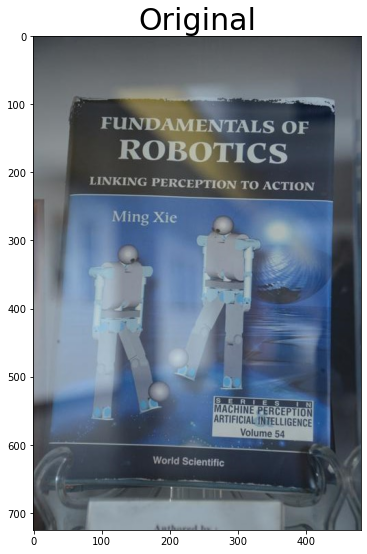

In [25]:
print("Forma: " + str(InputLibro.shape))
print("Tipo de la matriz: " + str(type(InputLibro)))

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgLibro,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

- Con 5 iteraciones:

In [26]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, ite=5)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

- Con 8 iteraciones:

In [27]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, ite=10)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    Por los resultados que estamos viendo, conforme mas iteraciones se realizan más se distorsiona la imagen ,por tanto, hay que encontrar el límite a partir del cual, la imagen se distorsiona, en esta parece que es a partir de la tercera       iteración.

Probamos con una imagen diferente:

Forma: (720, 1083, 3)
Tipo de la matriz: <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Original')

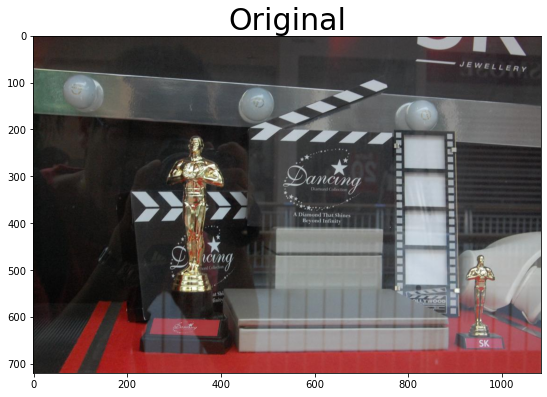

In [28]:
print("Forma: " + str(InputEstatuilla.shape))
print("Tipo de la matriz: " + str(type(InputEstatuilla)))

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgEstatuilla,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

- Con una iteración:

In [29]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputEstatuilla,50,lbEstatuilla,hbEstatuilla, ite=1)

# Mostrar resultados
cv2.imshow('original', InputEstatuilla)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

- Con 3 iteraciones:

In [30]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputEstatuilla,50,lbEstatuilla,hbEstatuilla, ite=3)

# Mostrar resultados
cv2.imshow('original', InputEstatuilla)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

- Con 5 iteraciones:

In [31]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputEstatuilla,50,lbEstatuilla,hbEstatuilla, ite=5)

# Mostrar resultados
cv2.imshow('original', InputEstatuilla)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    Sucede lo mismo, a partir de la tercera iteración se distorsiona demasiado la imagen, ademas en esta imagen en concreto, el resultado es algo peor de lo esperado ya que aun hay buena parte del reflejo visible y el color de la barra en la parte superior de la imagen.

Vamos a probar con otra imagen y 3 iteraciones a ver si el resultado sigue sin ser demasiado bueno.

Forma: (720, 1083, 3)
Tipo de la matriz: <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Original')

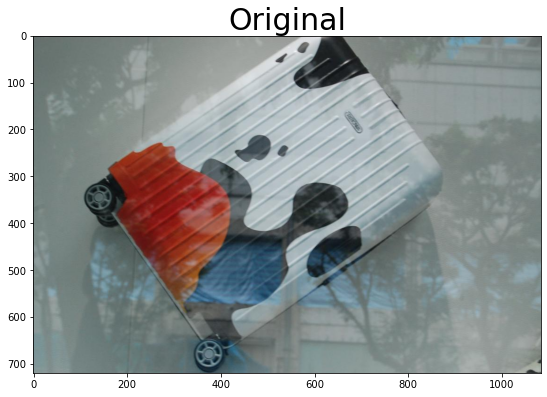

In [32]:
print("Forma: " + str(InputMaleta.shape))
print("Tipo de la matriz: " + str(type(InputMaleta)))

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgMaleta,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)


In [33]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputMaleta,50,lbMaleta,hbMaleta, ite=3)

# Mostrar resultados
cv2.imshow('original', InputMaleta)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    Los resultados siguen sin ser los mejores, por ello vamos a tratar de mejorarlos en la siguiente sección alterando el valor de los umbrales que definen la variable beta.

### 5.2. Alterando el valor del thr (beta). <a class="anchor" id="beta"></a>

##  $ \beta = 2^\frac{(i-1)}{thr}$

Beta actúa en la fórmula del cálculo de L1 dando peso a los filtros f1 y f2 y forma parte del valor umbral de la actualización de g (1/beta). 

En la actualización de g tenemos una convolución en el dominio del espacio que detecta los bordes de la imagen, para cada valor de g se comprueba si es inferior al umbral, esos valores que son inferiores al umbral son considerados como bordes del reflejo ya que no son lo suficientemente fuertes para pertenecer a los bordes del fondo, aumentar su valor implica disminuir ese umbral de la actualización de g y aumentar el peso de la convolución de g en el cálculo de L1.

Por tanto si beta toma un valor muy grande la imagen del fondo L1 obtenida será muy similar a la original, ya que al disminuir el umbral "se dejan pasar" todos los bordes de la imagen original y se le da un peso muy grande a ese cálculo en la fórmula del cálculo de L1.

Text(0.5, 1.0, 'Original')

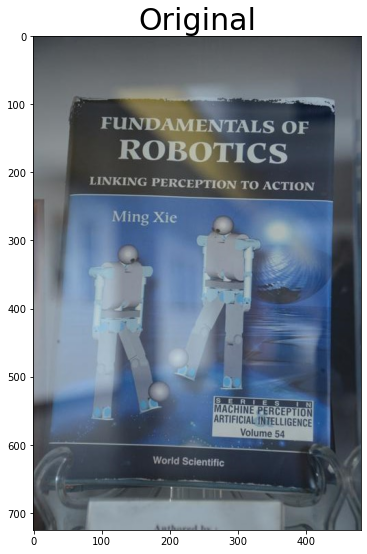

In [34]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgLibro,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

Hacemos una prueba con un valor muy alto y muy bajo para probar lo que hemos dicho sobre los casos extremos de beta:

In [35]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, thr=0.000000000000000000000000000000000000001)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [36]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, thr=10000000000000000000000000)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

Probando con algunos valores distintos para ver los resultados:

- thr=0.1:

In [37]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, thr=0.1)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    A primera vista parece que con el nuevo valor thr=0.1 el algoritmo proporciona mejores resultados. Probamos con el resto de imágenes anteriores con valores para thr menores y mayores.

- thr=0.025:

In [38]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, thr=0.025)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    El resultado para thr=0.025 parece empeorar, por ello utilizamos un valor mayor que el inicial.

- thr=0.125

In [39]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,50,lbLibro,hbLibro, thr=0.125)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    Con este valor más alto parece que se consigue eliminar una mayor cantidad de reflejo pero la imagen correspondiente al fondo parece tener un muy bajo contraste (al menos en este caso). Sería interesante visualizar el histograma con los distintos niveles de gris de la imagen para comprobar si esto se produce y si una ecualización posterior solucionaría el problema o si mejoraría los resultados con respecto a otros parámetros que hemos ido alternando en esta sección de experimentación.

Text(0.5, 1.0, 'Original')

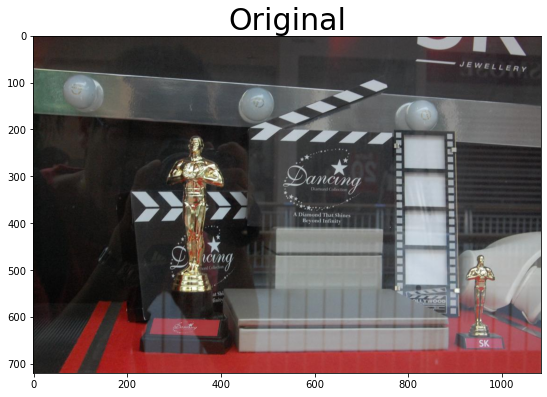

In [40]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgEstatuilla,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

In [41]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputEstatuilla,50,lbEstatuilla,hbEstatuilla, thr=0.1)

# Mostrar resultados
cv2.imshow('original', InputEstatuilla)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    Se elimina un poco mas de reflejo pero no termina de salir un buen resultado, probamos con el siguiente valor que usamos anteriormente, 0.125:

In [42]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputEstatuilla,50,lbEstatuilla,hbEstatuilla, thr=0.5)

# Mostrar resultados
cv2.imshow('original', InputEstatuilla)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    Parece que el resultado no mejora tampoco, probamos ahora con la imagen de la maleta con los mismos valores.

Text(0.5, 1.0, 'Original')

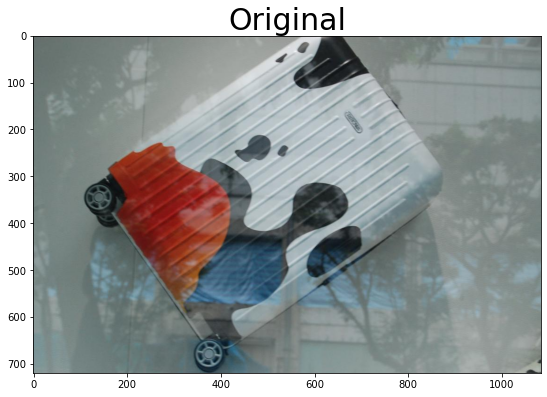

In [43]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgMaleta,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

- thr=0.1:

In [44]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputMaleta,50,lbMaleta,hbMaleta, thr=0.1)

# Mostrar resultados
cv2.imshow('original', InputMaleta)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

- thr=0.125:

In [45]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputMaleta,50,lbMaleta,hbMaleta, thr=0.125)

# Mostrar resultados
cv2.imshow('original', InputMaleta)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

    En este caso, si que se aprecia como desaparece mayor cantidad de reflejo, a cambio perdemos un poco de la intensidad de los colores, pero es un resultado mejor ya que con un tratamiento posterior a este resultado, se podria conseguir la imagen completa sin el reflejo.

### 5.3. Alterando el valor de lambda. <a class="anchor" id="lambda"></a>

Como se indica en el artículo, el parámetro lambda se utiliza para controlar la "suavidad" que se impone a la capa L2, en nuestro caso describe la intensidad del reflejo de la imagen original, es un parámetro que hay que ajustar dependiendo de la intensidad del reflejo de la imagen. De esta forma, la configuración de este parámetro con distintos valores puede proporcionarnos otra visión acerca de como ajustar con mayor precisión el algoritmo en según que casos.

Lo que se intenta conseguir con labda y el filtro laplaciano es recuperar partes que se hayan eliminado como reflejo de la imagen original y que no lo eran (en funcion de la suposición inicial de como de intensa es la capa del reflejo).

Text(0.5, 1.0, 'Original')

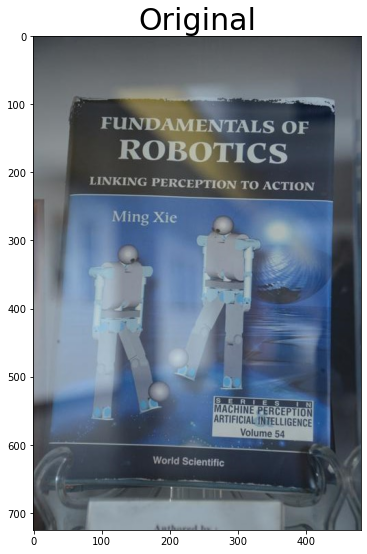

In [46]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgLibro,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

Probamos primero con el valor 0, esto supone eliminar de la fórmula el filtro f3 (Laplaciano), eliminar este filtro supone que la convolución del filtro laplaciano no aporta nada a L1, es decir, no intenta recuperar nada de la imagen original con tras el procesado mediante la convolución de g, lo que significa que la mayor parte de la imagen original es reflejo y L1 solo depende de la variable g.

In [47]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,0,lbLibro,hbLibro)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

Probamos con un valor un poco más alto que los anteriores que hemos probado (0 y 50), 80:

In [48]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,80,lbLibro,hbLibro)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

Como se ve, ahora hay menos partes del reflejo eliminadas, esto se debe a que al elevar el factor que indica la suavidad relativa de la capa del reflejo, se han recuperado partes de la imagen original en L1 que no debian ser recuperadas, ya que la intensidad real del reflejo de la imagen no es tan fuerte.

Si le decimos al algoritmo que la intensidad del reflejo es demasiado alto, debe considerar que muy poco de la imagen es reflejo (el peso de la convolución de la imagen original con el laplaciano gana mucha fuerza), por tanto la salida debe ser muy parecida a la entrada.

In [49]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputLibro,100000,lbLibro,hbLibro)

# Mostrar resultados
cv2.imshow('original', InputLibro)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

Vamos a hacer pruebas con la siguiente imagen para ver si mejora los resultados que obteniamos haciendo variaciones de iteraciones y cambiando los valores de beta mediante thr (umbral), según lo que hemos probado antes, para eliminar mayor cantidad de reflejo, debemos disminuir la suavidad relativa de la capa del reflejo L2, de este modo habra una mayor cantidad de la imagen que sea considerada reflejo.

Text(0.5, 1.0, 'Original')

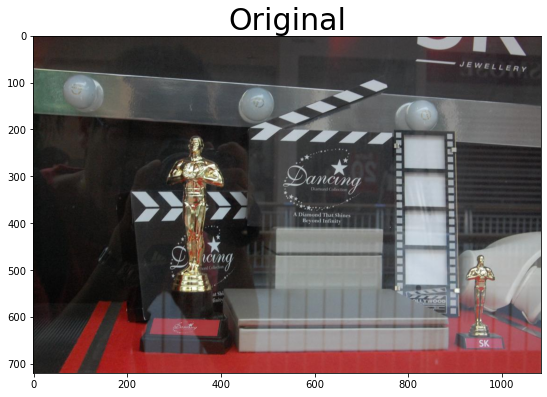

In [50]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgEstatuilla,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

Para probar con valores más bajos de suavidad relativa empezamos con 20:

In [51]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputEstatuilla,20,lbEstatuilla,hbEstatuilla)

# Mostrar resultados
cv2.imshow('original', InputEstatuilla)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

El resultado es mejor que los obtenidos anteriormente, pero la imagen empieza a distorsionarse debido a que partes que son del fondo están siendo consideradas reflejo, si seguimos decrementando lambda obtendremos resultados peores.

La imagen de la maleta parece mejorable y más facil de tratar que la imagen de la estatuilla, si tratamos de cambiar el valor de lambda para la fotografía de la maleta es posible que nos salga mejor.

Text(0.5, 1.0, 'Original')

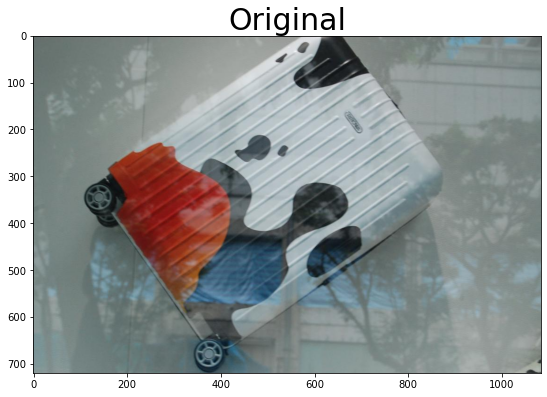

In [52]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(imgMaleta,cv2.COLOR_BGR2RGB))
plt.title("Original",fontsize=30)

Probamos con un valor de 20:

In [53]:
# Ejecucion del algoritmo
a,b=septRelSmo(InputMaleta,20,lbMaleta,hbMaleta)

# Mostrar resultados
cv2.imshow('original', InputMaleta)
cv2.imshow('imagen', a)
cv2.imshow('reflejo', b)

cv2.waitKey(0)
cv2.destroyAllWindows()

Un poco mejor, pero tenemos el mismo problema, si seguimos bajando, demasiado del fondo se empieza a considerar reflejo.

### 5.4. Comprobando salidas de partes de la fórmula de L1  <a class="anchor" id="partesL1"></a>

Con el fin de tratar de visualizar un poco lo que está sucediendo en cada parte de la fórmula del cálculo de L1, hemos hecho una versión simplificada de la función que nos retorna las matrices siguientes devolviendolas al dominio del espacio:

- (pruebaNormin1) Matriz con el factor que multiplica a lambda:

### $\lambda(\mathcal{F}(F^3)⋆\mathcal{F}(F^3)\mathcal{F}(I))$
    
    
- (pruebaNormin2) Matriz con el factor que multiplica a beta:

### $\beta\sum_{j}(\mathcal{F}(F^j)⋆\mathcal{F}(g^j))$
    
    
- (pruebaDeormin1) Matriz de convolución multiplicada por lambda en el denominador:

### $\lambda(\mathcal{F}(F^3)⋆\mathcal{F}(F^3))$
    
    
- (pruebaDeormin2) Matriz de convolución multiplicada por beta en el denominador:

### $\beta\sum_{j}(\mathcal{F}(F^j)⋆\mathcal{F}(F^j))$
    
  
- (pruebaSolo1) Matriz de la convolución con el laplaciano con su deconvolución:

## $\frac{\lambda(\mathcal{F}(F^3)⋆\mathcal{F}(F^3)\mathcal{F}(I))}{\lambda(\mathcal{F}(F^3)⋆\mathcal{F}(F^3))}$
    
    
- (pruebaSolo2) Matriz de la convolución de la parte de g con su deconvolución:


## $\frac{\beta\sum_{j}(\mathcal{F}(F^j)⋆\mathcal{F}(g^j))}{\beta\sum_{j}(\mathcal{F}(F^j)⋆\mathcal{F}(F^j))}$
    
    
- (pruebaL1) Matriz de L1


# $\frac{\beta\sum_{j}(\mathcal{F}(F^j)⋆\mathcal{F}(g^j)) + \lambda*(\mathcal{F}(F^3)⋆\mathcal{F}(F^3)\mathcal{F}(I))}{\beta\sum_{j}(\mathcal{F}(F^j)⋆\mathcal{F}(F^j)) + \lambda*(\mathcal{F}(F^3)⋆\mathcal{F}(F^3))}$

In [54]:
def septRelSmoTests(I):
    """Funcion de separacion de reflejo de una imagen para
    hacer pruebas:
    ----------
    I: `numpy.ndarray` con valores float de 0. a 1.
        matriz de entrada que representa la imagen
    Salida:
    ----------
    pruebaNormin1: `numpy.ndarray`
        lamb*Normin1
    pruebaNormin1: `numpy.ndarray`
        beta*Normin2
    pruebaDenormin1: `numpy.ndarray`
        lamb*Denormin1
    pruebaDenormin2: `numpy.ndarray`
        beta*Denormin2
    pruebaSolo1: `numpy.ndarray`
        (lamb*Normin1)/(lamb*Denormin1+eps)
    pruebaSolo2: `numpy.ndarray`
        (beta*Normin2)/(beta*Denormin2+eps)
    pruebaL1: `numpy.ndarray`
        (lamb*Normin1 + beta*Normin2)/(Denormin + eps)
    """       
    
    lamb = 50
    lb = np.zeros(I.shape)   
    hb = I
    
    if len(I.shape)==2:
        I = np.dstack([I]*1)
        lb = np.dstack([lb]*1)
        hb = np.dstack([hb]*1)

    L1_0 = copy.deepcopy(I)
    
    # tamaño de la matriz/imagen original n x m x d
    n,m,d = I.shape    
    
    # Filtros    
    f1 = np.array([[1,-1]])
    f2 = np.array([[1],
                   [-1]])
    # f3 es el filtro laplaciano
    f3 = np.array([[0,-1,0],
                 [-1,4,-1],
                 [0,-1,0]])
    
    
    # Calcular las OTF asociadas a cada filtro haciendo uso de 
    # la funcion auxiliar psf2otf
    sizeI2D = (n,m)
    otfFx = psf2otf(f1,sizeI2D)
    otfFy = psf2otf(f2,sizeI2D)
    otfL = psf2otf(f3,sizeI2D)
    
    # Calculo de FFT de la imagen de entrada por capas/canales
    fft2I = np.empty(I.shape).astype('complex128')
    for c in range(d):
        fft2I[:,:,c] = np.fft.fft2(I[:,:,c])
    
    
    # Partes de la formula (8) (Compute) que pueden ser precalculadas

    # FFT(F3)*FFT(F3)FFT(I) = ((F3)^2)FFT(I) donde * es el complejo conjugado
    Normin1 = np.power(np.dstack([np.absolute(otfL)]*d),2) * fft2I

    
    # FFT(F3)*FFT(F3) = (F3)^2 donde * es el complejo conjugado
    Denormin1 = np.power(np.absolute(otfL),2)
    
    # sum_j(FFT(Fj)*FFT(Fj)) = sum_j((Fj)^2) donde * es el complejo conjugado
    #     y j es un valor perteneciente a {1,2}, es decir, Fj es otfFx u otfFy
    Denormin2 = np.power(np.absolute(otfFx),2) + np.power(np.absolute(otfFy),2)

    
    
    # Igualar la cantidad de canales que tiene la imagen original
    if d>1:
        Denormin1 = np.dstack([Denormin1]*d)
        Denormin2 = np.dstack([Denormin2]*d)

        
    # Constante de la formula (8)
    eps = 10**(-16)    
    thr = 0.05
    
    # Inicializar L1
    L1 = L1_0
    
    # Realizar 3 iteraciones variando el valor de beta
    # Inicializar beta
    beta = 2**(1-1)/thr

    # Inicializar Denormin de formula (8) con los valores del precalculo
    Denormin = lamb * Denormin1 + beta * Denormin2
    if len(Denormin.shape)==2:
        Denormin=np.dstack([Denormin]*1)

    # Actualizar g_j_i con la formula (7)

    # Aplicar los filtros f1 y f2 a L1
    gFx = -cv2.filter2D(L1, -1, f1, anchor=(-1,-1),delta=0,borderType=cv2.BORDER_REFLECT_101)
    gFy = -cv2.filter2D(L1, -1, f2, anchor=(-1,-1),delta=0, borderType=cv2.BORDER_REFLECT_101)

    if len(gFx.shape) == 2:
        gFx = np.dstack([gFx]*1)
        gFy = np.dstack([gFy]*1)

    # t_x y t_y son acumuladores, contienen el valor de la suma de los d
    # canales en cada pixel, si este valor es menor que el umbral,
    # el valor de ese pixel en cada canl se cambia a 0.

    for fila in range(n):
        for columna in range(m):
            t_x = 0
            t_y = 0
            for canal in range(d):
                t_x += abs(gFx[fila,columna,canal])
                t_y += abs(gFy[fila,columna,canal])
                # gFx(t) = 0;
            if t_x < 1/beta:
                for canal in range(d):
                    gFx[fila,columna,canal] = 0
            if t_y < 1/beta:
                for canal in range(d):
                    gFy[fila,columna,canal] = 0


    # Calculo de L1

    # Solo queda por calcular la parte de la formula (7) sum_j(FF(Fj)*FFT(gj))
    # que se resuelve usando la propiedad de la transformada de fourer de la
    # transformada de la convolucion.

    # j == 1 primer filtro

    temp = gFx[:,m-1,:] - gFx[:,0,:]    # Se obtiene una columna por canal
    diff = -np.diff(gFx, 1, 1)          # tiene las dimensiones de siempre
    Normin2 = np.empty((n,m,d))


    temporalAux = np.empty((n,1,d))
    for c in range(d):
        temporalAux[:,0,c] = temp[:,c]

    for dim in range(0,d): 
        Normin2[:,:,dim] = np.column_stack((temporalAux[:,0,dim], diff[:,:,dim]))

    # j == 2 segundo filtro

    temp = gFy[n-1,:,:] - gFy[0,:,:]
    diff = -np.diff(gFy,1,axis = 0)
    Normin2_aux = np.empty((n,m,d))

    temporalAux = np.empty((1,m,d))
    for c in range(d):
        temporalAux[0,:,c] = temp[:,c]
    for dim in range(0,d):
        Normin2_aux[:,:,dim] = np.vstack((temporalAux[0,:,dim],diff[:,:,dim]))


    Normin2 = Normin2 + Normin2_aux

    Normin2 = Normin2.astype('complex128')
    for c in range(d):
        Normin2[:,:,c] = np.fft.fft2(Normin2[:,:,c])

    # (lamb*Normin1 + beta*Normin2)/(Denormin + eps)
    testNormin1 = lamb*Normin1
    testNormin2 = beta*Normin2
    testDenormin1 = lamb*Denormin1
    testDenormin2 = beta*Denormin2
    testSolo1 = (lamb*Normin1)/(lamb*Denormin1+eps)
    testSolo2 = (beta*Normin2)/(beta*Denormin2+eps)
    testL1 = (lamb*Normin1 + beta*Normin2)/(Denormin + eps)
    
    pruebaNormin1 = np.empty((testNormin1.shape)).astype('float64')
    pruebaNormin2 = np.empty((testNormin2.shape)).astype('float64')
    pruebaDenormin1 = np.empty((testDenormin1.shape)).astype('float64')
    pruebaDenormin2 = np.empty((testDenormin2.shape)).astype('float64')
    pruebaSolo1 = np.empty((testSolo1.shape)).astype('float64')
    pruebaSolo2 = np.empty((testSolo2.shape)).astype('float64')
    pruebaL1 = np.empty((testL1.shape)).astype('float64')

    for c in range(d):
        pruebaNormin1[:,:,c] = np.real(np.fft.ifft2(testNormin1[:,:,c]))
    for c in range(d):
        pruebaNormin2[:,:,c] = np.real(np.fft.ifft2(testNormin2[:,:,c]))
    for c in range(d):
        pruebaDenormin1[:,:,c] = np.real(np.fft.ifft2(testDenormin1[:,:,c]))
    for c in range(d):
        pruebaDenormin2[:,:,c] = np.real(np.fft.ifft2(testDenormin2[:,:,c]))
    for c in range(d):
        pruebaSolo1[:,:,c] = np.real(np.fft.ifft2(testSolo1[:,:,c]))
    for c in range(d):
        pruebaSolo2[:,:,c] = np.real(np.fft.ifft2(testSolo2[:,:,c]))
    for c in range(d):
        pruebaL1[:,:,c] = np.real(np.fft.ifft2(testL1[:,:,c]))
                                  
    return pruebaNormin1,pruebaNormin2,pruebaDenormin1,pruebaDenormin2,pruebaSolo1,pruebaSolo2,pruebaL1

Para visualizar los resultados deseados comentamos o descomentamos los "imshow" de OpenCV en función de lo que queremos ver:

In [55]:
pruebaNormin1,pruebaNormin2,pruebaDenormin1,pruebaDenormin2,pruebaSolo1,pruebaSolo2,pruebaL1 = septRelSmoTests(InputLibro)

#cv2.imshow('pruebaNormin1', pruebaNormin1)
#cv2.imshow('pruebaNormin2', pruebaNormin2)
#cv2.imshow('pruebaDenormin1', pruebaDenormin1)
#cv2.imshow('pruebaDenormin2', pruebaDenormin2)
cv2.imshow('pruebaSolo1', pruebaSolo1)
cv2.imshow('pruebaSolo2', pruebaSolo2)
cv2.imshow('pruebaL1', pruebaL1)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 6. Conclusiones. <a class="anchor" id="conclusiones"></a>

- De alterar el número de iteraciones:

    Lo que conseguimos aumentando el número de iteraciones es realizar más pasadas por el algoritmo donde en cada pasada se aumenta $\beta$ por 2, si en la iteración anterior obtuvimos una versión de L1 con menor cantidad de reflejo, en la iteración actual se trata de volver a pasar por las 3 partes destacadas del algoritmo, la actualización de $\mathcal{g}$ va a tener un umbral menor ya que es inversamente proporcional a $\beta$ y esto causará que $\mathcal{g}$ sea menos restrictiva en cuanto a permitir la aparición de ciertos bordes, también se da mas importancia a la convolución de los filtros de primer orden por la relevancia de $\beta$ en la fórmula de L1.
    
    Al tratar la imagen por sus distintas capas de colores, si elevamos el número de iteraciones un número excesivamente alto, no solo se altera la imagen en forma, sino tambien en color ya que cada canal procesar los picos del gradiente sin tener en cuenta el resto de canales como si fuesen imagenes distintas.


- De alterar el valor de thr ($\beta = 2^\frac{(i-1)}{thr}$):

    Por lo que hemos visto, mayores valores de thr implican aumentar $\beta$, lo cual significa dar mayor importancia a la convolución con los filtros de primer orden respecto al filtro laplaciano con la imagen original, es decir, se converge más rapido a una solución donde se elimine el reflejo, pero esto implica alejarse de la imagen original, se pierde mucha claridad, sin embargo, con valores excesivamente altos terminaremos por dejar L1 (capa del fondo) muy similar a la imagen original, ya que al hacer la umbralización en la actualización de $\mathcal{g}$ todos los valores pasan el umbral y después el cálculo de L1 el peso de esa convolución es mucho mayor que la convolución del laplaciano con la imagen original. 
    
    Tomar valores muy bajos de $\beta$ impide que ningún valor en actualización de $\mathcal{g}$ sea capaz de pasar el umbral por tanto L1 quedará en negro.

    
- De alterar el valor de $\lambda$:

    El artículo dice que $\lambda$ representa una estimación que hacemos de la suavidad relativa de la capa L2 en la separación de capas, para nuestro caso de la eliminación del reflejo, como hemos supuesto y visto en las pruebas, $\lambda$ estima la intensidad del reflejo en la imagen, es decir, lo intensa que es la capa L2, para valores altos de $\lambda$, damos más peso a la parte del filtro laplaciano en la fórmula del cálculo de L1, lo cual implica que en cada iteración se elimina menor cantidad de reflejo ya que el peso de la convolución de la variable g es mucho menor, con un valor de $\lambda$ extremadamente alto conseguiremos una L1 muy parecida a la imagen original. 
    
    Si tomamos $\lambda$ con un valor de 0 lo que hacemos es eliminar ese filtro laplaciano de la fórmula del cálculo de L1 y estamos diciendole al algoritmo que la intensidad del reflejo es extremadamente alta, por tanto en la fórmula del cálculo de L1 se eliminan todos los bordes que no superan el umbral durante la actualización de $\mathcal{g}$.
    
    
- Comprobando salidas de partes de la fórmula de L1:

    Para hacer un poco más visual las entrañas del algoritmo, hemos decidido hacer una versión que retorne las matrices de los pasos intermedios del cálculo de L1, esto nos ha enseñado que en efecto, la parte de la convolución del laplaciano trata de capturar todos los bordes de la imagen con el fin de recuperar partes de la imagen que han podido perderse con la convolución de los filtros de primer orden en la actualización de $\mathcal{g}$, tomando como criterio el valor de $\lambda$ que nos indica la intensidad que suponemos en la capa del reflejo (a mayor lambda, menor intensidad de reflejo), todo esto lo deducimos de la fórmula y de la salida de esta comrpobación que llamamos "pruebaSolo1". 
    
    También nos muestra la parte de la convolución con los filtros de primer orden, tras la actualización de $\mathcal{g}$, donde vemos que en efecto aquí es donde se trata de eliminar el reflejo, lo vemos en la salida que llamamos "pruebaSolo2".

## 7. Referencias. <a class="anchor" id="referencias"></a>

[1] https://es.wikiversity.org/wiki/Propiedades_de_la_transformada_de_Fourier <a class="anchor" id="propiedades"></a>

[2] https://github.com/aboucaud/pypher/blob/master/pypher/pypher.py <a class="anchor" id="enlacePSF2OTF"></a>

[3] https://openaccess.thecvf.com/content_cvpr_2014/papers/Li_Single_Image_Layer_2014_CVPR_paper.pdf <a class="anchor" id="articulo"></a>

[4] https://yu-li.github.io <a class="anchor" id="code"></a>
